# TP1 - Energy Consumption Prediction

# Introduction

You will learn :
* Some Fondamentales of Data Science
* Manipulate Timeseries with Jupyter Notebook

# Statement : Energy Consumption
## Overview
To better follow the energy consumption, the government wants energy suppliers to install smart meters in every home in England, Wales and Scotland. There are more than 26 million homes for the energy suppliers to get to, with the goal of every home having a smart meter by 2020.

This roll out of meter is lead by the European Union who asked all member governments to look at smart meters as part of measures to upgrade our energy supply and tackle climate change. After an initial study, the British government decided to adopt smart meters as part of their plan to update our ageing energy system.

In this dataset, you will find a refactorised version of the data from the London data store, that contains the energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014. The data from the smart meters is associated only to the electrical consumption.

**Approach :**

1. Combine all blocks into a single dataframe - keeping only relevant columns.

2. Use day-level energy consumption data per household to normalize data for inconsistent household count

3. Explore relationships between weather conditions and energy consumptions.

4. Add UK holidays data to the day level data as an indicator.

5. Fit an ARIMA model
   
6. Fit a PROPHET model


You will have these datasets : 

- Weather dataset : **datasets_weather_daily_darksky.csv**
- Holidays dataset : **datasets_uk_bank_holidays.csv**
- Folder named **daily_dataset** that contains 112 datasets on energy


## 1 - Load data from s3

First, we will combine all files  of the folder **daily_dataset/** into one dataframe and we will save the dataframe as a csv file into the folder **data/** under the name of **energy.csv** :

In [3]:
import pandas as pd

In [4]:
# Combining all blocks
import glob
df_all_blocks = pd.concat([pd.read_csv(f) for f in glob.glob('data/daily_dataset/block_*.csv')], ignore_index=True)
df_all_blocks = df_all_blocks[['day','LCLid','energy_sum']]
    
df_all_blocks.to_csv("data/energy.csv", ignore_index = True)

Let's try it in S3

In [ ]:
import boto3

s3 = boto3.resource('s3')
bucket = s3.Bucket('tp-bucket')
prefix_objs = bucket.objects.filter(Prefix="data/daily_dataset")
prefix_df = []
for obj in prefix_objs:
    key = obj.key
    body = obj.get()['Body'].read()
    df = pd.DataFrame(body)
    prefix_df.append(df)

Now, we will import weather and holidays csv into two dataframes **weather** and **holiday** :

In [190]:
weather = pd.read_csv('data/datasets_weather_daily_darksky.csv')
holiday= pd.read_csv('data/datasets_uk_bank_holidays.csv')

Let's  also import energy.csv  into one dataframe **energy** : 

In [251]:
energy = pd.read_csv('data/energy.csv')
len(energy)

3510433

Now verify that the **energy** dataframe has a length of 3 510 433 rows and 3 columns.

In [252]:
energy.head()

Unnamed: 0         day      LCLid  energy_sum
0           0  2011-12-07  MAC000027       3.997
1           1  2011-12-08  MAC000027       9.287
2           2  2011-12-09  MAC000027       7.525
3           3  2011-12-10  MAC000027      12.684
4           4  2011-12-11  MAC000027      13.845

## 2 - Preparing and cleaning the data

**House Count**


We will now verify if we have the same number of household for each day. To do so, let's count the number of distinct household ( distinct LCLid ) per day : 

**Tips :** use the groupby() and nunique() method

In [192]:
housecount = energy.groupby('day')[['LCLid']].nunique()
housecount = housecount.rename(columns = {'LCLid': 'household_count'})
housecount.head(4)

household_count
day                        
2011-11-23               13
2011-11-24               25
2011-11-25               32
2011-11-26               41

Run the plot command to see the evolution of household count with time

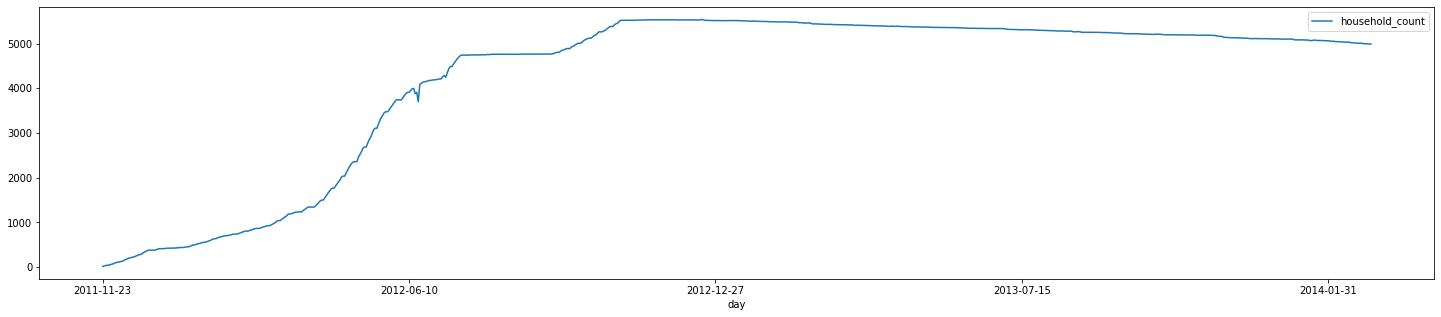

In [193]:
housecount.plot(figsize=(25,5))


In the dataset we see that the number of households for which energy data was collected across different days are different. This is probably due to the gradually increasing adoption of smart meters in London. This could lead to false interpretation that the energy for a particular day might be high when it could be that the data was only collected for more number of houses.

### Normalization across households

The data collection across households are inconsistent- therefore we will be using the average energy per day as the target to predict rather than energy per household. It means that for our prediction, we will predict the average energy consumption of all meters together per day instead of predicting one consumption per day for each meter.

To do so, we will need to : 

**1 -** compute the energy_sum for each day

**2 -** compute the column household_count per day

**3 -** compute the avg_energy by dividing energy_sum and household_count

So, let us first compute the energy sum for each day by grouping by day and additioning the energy column. We will name it **energy_sum** : 

**Tips :** you can use the method groupby() and sum()


In [194]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy.head(2)

energy_sum
day                   
2011-11-23      90.385
2011-11-24     213.412

Now, we will create a column called **household_count** that contains for each day the number of distinct household : 

**Tips :** you can merge the row you computed in the part "House Count" of the lab with the energy df

In [195]:
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()
energy.head(2)

day  energy_sum  household_count
0  2011-11-23      90.385               13
1  2011-11-24     213.412               25

We will compute average energy **avg_energy** by dividing **energy_sum** and **household_count** : 

In [197]:
energy['avg_energy'] =  energy['energy_sum']/energy['household_count']

In [198]:
energy.head(2)

day  energy_sum  household_count  avg_energy
0  2011-11-23      90.385               13    6.952692
1  2011-11-24     213.412               25    8.536480

In [249]:
len(energy)

829

We now have a dataframe of 829 rows with the following columns :

- day
- energy_sum
- household_count
- avg_energy

## 3 - Feature engineering

### Merging all dataframes

We want to enrich the energy dataframe by adding to it the columns holiday and weather. To do so we need to merge the 3 dataframes.

To perform the merge between energy and weather dataframes, we first need to convert the column **day** of the energy dataframe and column **time** of weather dataframe to type date (by using  dt.date). We will also rename **time** column into **day** : 

In [200]:
energy['day'] = pd.to_datetime(energy['day'],format='%Y-%m-%d').dt.date
weather['day']=  pd.to_datetime(weather['time']).dt.date # day is given as timestamp

Using the datafralme weather, we will compute the **mean_temperature** by taking the average of **temperatureMax** and **tempertaureMin**. We will also keep only the columns we need. So the dataframe weather will be containing : 

- day
- mean_temperature

In [201]:
weather['mean_temperature'] = weather[['temperatureMax', 'temperatureMin']].mean(axis=1)
weather = weather[['mean_temperature', 'day']]
weather = weather.dropna()

We can finally merge energy and weather dataframe. The number of rows should stay equal to 829. The output will contain : 

- day
- energy_sum
- household_count
- avg_energy
- mean_temperature

In [202]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)

day  energy_sum  household_count  avg_energy  mean_temperature
0  2011-11-23      90.385               13    6.952692             7.085
1  2011-11-24     213.412               25    8.536480            10.745

Now you can plot on the same graph the **avg_energy** and the **mean_temperature** according to time : 

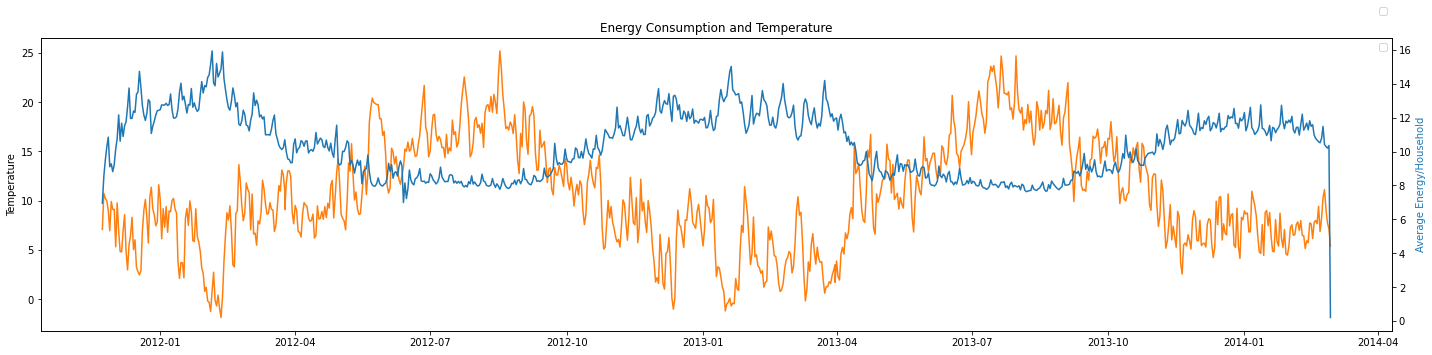

In [203]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy['day'], weather_energy['mean_temperature'], color = 'tab:orange')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy['day'],weather_energy['avg_energy'],color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

We can see that energy and temperature are **negatively correlated**. 

### Holidays 

To be able to merge the **holiday** dataframe with our **weather_energy** dataframe, we  need to convert the column **Bank holidays** into date type : 

In [204]:
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.head(4)

Bank holidays                                          Type
0    2012-12-26                                    Boxing Day
1    2012-12-25                                 Christmas Day
2    2012-08-27                           Summer bank holiday
3    2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)

Now we can perform the merge :

In [ ]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')

**Dummy variables**

A dummy variable is one that takes only the value 0 or 1 to indicate the absence or presence of some categorical effect that may be expected to shift the outcome.

We will create a column called **holiday_ind** containing 1 if the date is a  holiday and 0 otherwise so the model can understand this. variable

In [206]:
import numpy as np
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

In [207]:
weather_energy.head(2)

day  energy_sum  household_count  avg_energy  mean_temperature  \
0  2011-11-23      90.385               13    6.952692             7.085   
1  2011-11-24     213.412               25    8.536480            10.745   

  Bank holidays Type  holiday_ind  
0           NaN  NaN            0  
1           NaN  NaN            0

For the end of this feature engineering part, we will keep in our dataframe only the columns we will need for the modeling, which are : 

- day
- avg_energy
- mean_tempertaure
- holiday_ind 

In [208]:
model_data = weather_energy[['day','avg_energy', 'mean_temperature', 'holiday_ind']]

### Try Some Models & Evaluate

* Arima
* Prophet

Split into training and testing datasets. We will take the last 30 days as testing dataset :

In [209]:
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

Plot the two datasets as timeseries : 

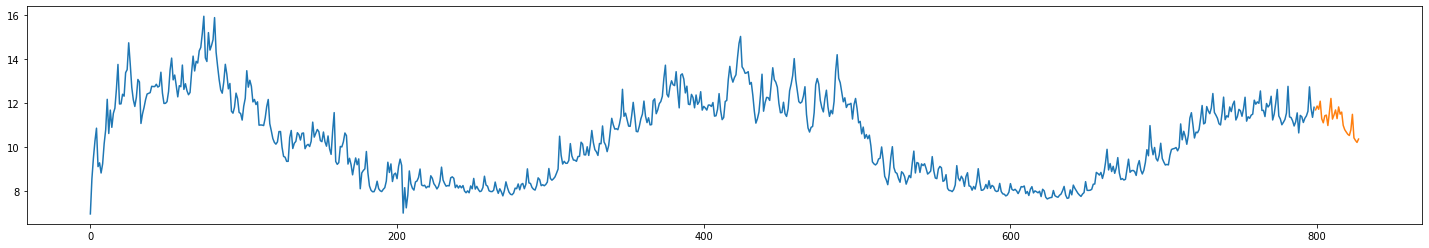

In [211]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))

## SARIMA Seasonal Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

We will now create an SARIMAX model using the statsmodels library. We will give the model **avg_energy** as an endogenous variable and **mean_tempertaure** and **holiday_ind** as exogenous variables. 

- An endogenous variable is a dependent variable. It is the variable we wish to explain.
- An exogenous variable is a variable that is not affected by other variables in the system. It is an independant variable. It helps the model to explain the endogenous variable.

### How to Configure SARIMA

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

**Trend Elements**
There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

 - p: Trend autoregression order.
 - d: Trend difference order.
 - q: Trend moving average order.

**Seasonal Elements**
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

 - P: Seasonal autoregressive order.
 - D: Seasonal difference order.
 - Q: Seasonal moving average order.
 - m: The number of time steps for a single seasonal period.
 
 We will use for our model **order = ( 7,1,1 ), seasonal_order = ( 1,1, 0, 12 )** : 

In [214]:
import statsmodels.api as sm

endog = train['avg_energy']
exog = sm.add_constant(train[['mean_temperature','holiday_ind']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog = exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          avg_energy   No. Observations:                  799
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 12)   Log Likelihood                -604.423
Date:                             Thu, 23 Jul 2020   AIC                           1236.845
Time:                                     17:28:47   BIC                           1302.183
Sample:                                          0   HQIC                          1261.966
                                             - 799                                         
Covariance Type:                               opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.0066      0.014     -0.468      0.640      -0.034       0.021
const            -2.039e-08   1.45e-09    -14.024      0.000   -2.32e-08   -1.75e-08
mean_temperature    -0.0642      0.007     -9.514      0.000      -0.077      -0.051
holiday_ind         -0.0278      0.082     -0.337      0.736      -0.189       0.133
ar.L1               -0.0265      0.095     -0.280      0.779      -0.212       0.159
ar.L2               -0.1891      0.039     -4.851      0.000      -0.266      -0.113
ar.L3               -0.1400      0.044     -3.157      0.002      -0.227      -0.053
ar.L4               -0.1928      0.043     -4.452      0.000      -0.278      -0.108
ar.L5               -0.1750      0.044     -3.988      0.000      -0.261      -0.089
ar.L6               -0.0068      0.044     -0.154      0.878      -0.093       0.079
ar.L7                0.3487      0.031     11.230      0.000       0.288       0.410
ma.L1               -0.2619      0.101     -2.601      0.009      -0.459      -0.065
ar.S.L12            -0.4923      0.034    -14.350      0.000      -0.560      -0.425
sigma2               0.2705      0.012     23.024      0.000       0.248       0.294
===================================================================================
Ljung-Box (Q):                      241.72   Jarque-Bera (JB):                29.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.69e+17. Standard errors may be unstable.
"""

Since we fitted our model, we can now plot on the same graph both **avg_energy** and fitted values by using **our_model.fittedvalues.plot()** : 

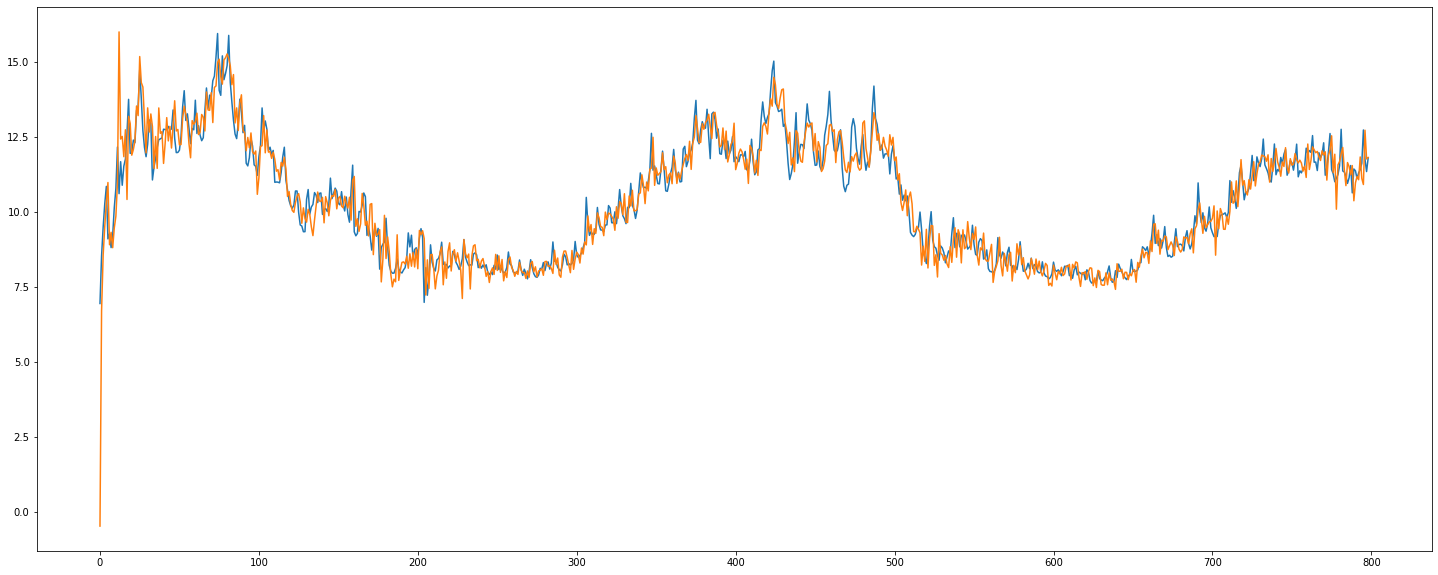

In [217]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

### Prediction on test dataset 

Now we will use the **predict** method on our testing dataset. The predict method takes as **start** argument the first index to predict and as **end** argument the last index to predict. Therefore, we will give **start = len(train) and end = len(train) + len(test) -1**

In [222]:
# predict takes as start the first index to predict and as end the  last index to predict
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(
    test[['mean_temperature','holiday_ind']]))


/Users/marwa.mahfoud/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


day  avg_energy  mean_temperature  holiday_ind  yhat_arima  \
823  2014-02-23   11.480411            10.305            0   10.981198   
824  2014-02-24   10.411403            11.110            0    9.960138   
825  2014-02-25   10.294997             9.110            0   10.731749   
826  2014-02-26   10.202945             7.730            0   11.241055   
827  2014-02-27   10.356350             7.120            0   10.934205   

     residual  
823  0.499213  
824  0.451265  
825  0.436752  
826  1.038110  
827  0.577855

We will add to the testing dataset a column called **yhat_arima** that contains the predicted values. We can get the predicted values by doing **prediction.values**  (prediction is equal to our_model.predict(...) :

In [ ]:
test['yhat_arima'] = predict.values
test.tail(5)

## Metrics

Plot predicted values and actual values for test dataset : 

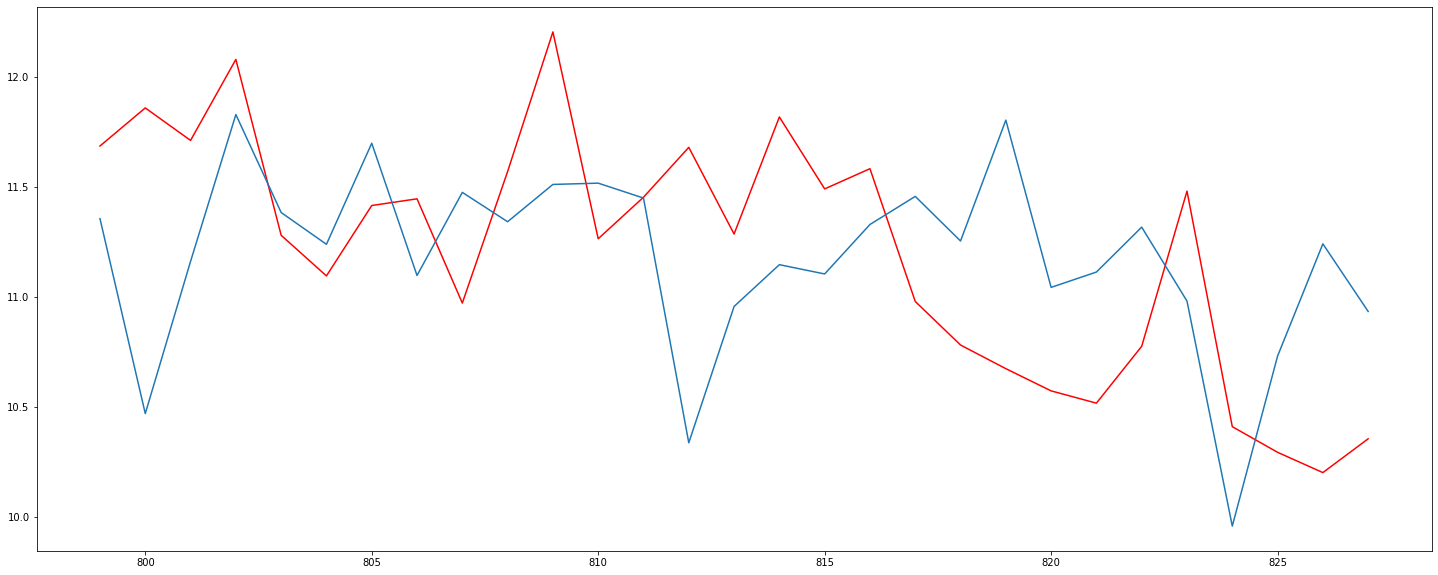

In [224]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['yhat_arima'].plot()
plt.show()

## Prophet Model

Time Series Modeling with Prophet
Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

To use Prophet modeling function , we need to name the date column as **ds** and the **avg_energy** column as **y** for train and test datasets :

In [227]:
test_for_prophet = test.rename(columns = {'avg_energy': 'y', 'day': 'ds'})
train_for_prophet = train.rename(columns = {'avg_energy': 'y', 'day':'ds'})


We can now apply the fit on training dataset and predict on testing dataset : 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


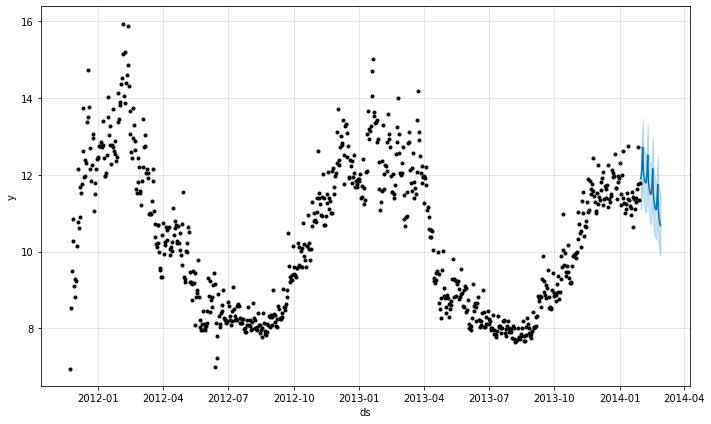

In [151]:
from fbprophet import Prophet


prophet_model = Prophet()
prophet_model.fit(train_for_prophet)

future  = test_for_prophet[['ds', 'y']]
forecast_energy_basic=prophet_model.predict(future)


To have a visual representation of our prediction, we  can do **our_model.plot(prediction)** : 

In [ ]:
fig1 =prophet_model.plot(forecast_energy_basic)

With Prophet, we can add  holidays and additional regressors. It gives the model more features to better predict the target. 

Let's create a new prophet model by adding holidays and regressors and plot the result :

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


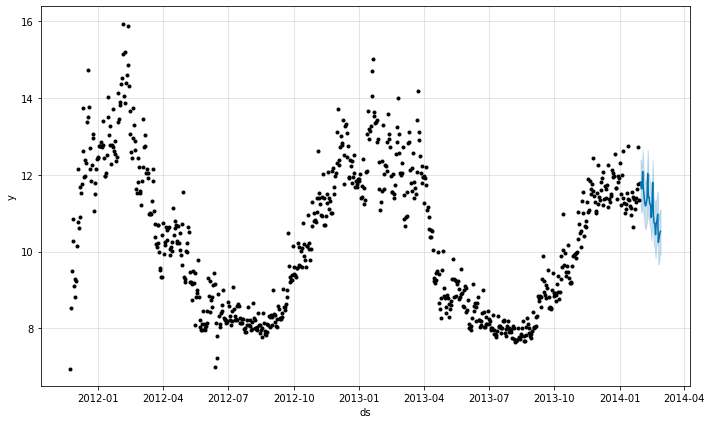

In [231]:

prophet_model_pro = Prophet()
prophet_model_pro.add_country_holidays(country_name='UK')
prophet_model_pro.add_regressor('mean_temperature')
prophet_model_pro.add_regressor('holiday_ind')

prophet_model_pro.fit(train_for_prophet)

future  = test_for_prophet
forecast_energy_pro=prophet_model_pro.predict(future)
fig1 =prophet_model_pro.plot(forecast_energy_pro)

## Forcast comparaison

As we have our 3 models trained, we want to compare them to see which one has the better performance.

To do so, we will create a dataframe with columns :

- **day**
- **yhat_arima** (our arima prediction)
- **yhat_pro_basic** (our prophet first model prediction)
- **yhat_pro_adv** (our prophet second model prediction)

In [232]:
forecast_energy_basic = forecast_energy_basic[['ds', 'yhat']]
forecast_energy_basic = forecast_energy_basic.rename(columns = {'yhat': 'yhat_pro_basic'})

In [233]:
forecast_energy_pro= forecast_energy_pro[['ds', 'yhat']]
forecast_energy_pro = forecast_energy_pro.rename(columns = {'yhat': 'yhat_pro_adv'})

In [234]:
comparaison_forcast = pd.merge(forecast_energy_basic, forecast_energy_pro, how = 'inner', left_on = 'ds', right_on = 'ds')

In [235]:
comparaison_forcast.head()

ds  yhat_pro_basic  yhat_pro_adv
0 2014-01-30       11.899483     11.791726
1 2014-01-31       11.961630     11.637007
2 2014-02-01       12.234006     11.650378
3 2014-02-02       12.716369     12.088710
4 2014-02-03       12.076574     11.623956

In [236]:
test_real_energy = test.reset_index()
test_real_energy = test_real_energy[['day', 'avg_energy', 'yhat_arima']]
test_real_energy['day'] = test_real_energy['day'].astype(str)
comparaison_forcast['ds'] = comparaison_forcast['ds'].astype(str)

In [237]:
all_forcast_comparaison = comparaison_forcast.merge(test_real_energy, how = 'inner', left_on='ds', right_on = 'day')

In [238]:
all_forcast_comparaison.head()

ds  yhat_pro_basic  yhat_pro_adv         day  avg_energy  \
0  2014-01-30       11.899483     11.791726  2014-01-30   11.685169   
1  2014-01-31       11.961630     11.637007  2014-01-31   11.857957   
2  2014-02-01       12.234006     11.650378  2014-02-01   11.710582   
3  2014-02-02       12.716369     12.088710  2014-02-02   12.078164   
4  2014-02-03       12.076574     11.623956  2014-02-03   11.280011   

   yhat_arima  
0   11.355570  
1   10.470756  
2   11.161724  
3   11.827789  
4   11.383329

Let us now plot the 3 predictions and the real energy value on the same plot to have a visual insight of the predictions :

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

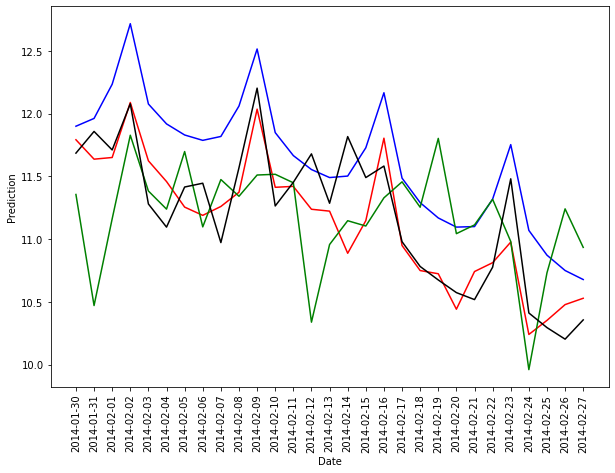

In [246]:
plt.figure(figsize=(10, 7))
plt.plot(all_forcast_comparaison['ds'], all_forcast_comparaison['yhat_pro_basic'], 'b-')
plt.plot(all_forcast_comparaison['ds'], all_forcast_comparaison['yhat_pro_adv'], 'r-')
plt.plot(all_forcast_comparaison['ds'], all_forcast_comparaison['yhat_arima'], 'g-')
plt.plot(all_forcast_comparaison['ds'], all_forcast_comparaison['avg_energy'], 'k-')
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.xticks(rotation=90);

### Metrics models

To end this comparaison, we will go more in details into these models. Let us compute for each model the :
    
- MSE Mean Square Error
- RMSE Root Mean Square Error
- MAPE Mean Absolute Percentage Error 


In [248]:
se = np.square(all_forcast_comparaison.loc[:, 'yhat_arima'] - all_forcast_comparaison.loc[:, 'avg_energy'])
mse = np.mean(se)
rmse = np.sqrt(mse)
residual = abs(all_forcast_comparaison.loc[:, 'yhat_arima'] - all_forcast_comparaison.loc[:, 'avg_energy'])
mape = (residual/all_forcast_comparaison['avg_energy']).sum()*100/len(all_forcast_comparaison)

print('ARIMA : \n mse = {} \n rmse = {} \n mape = {}'.format(mse, rmse, mape))

se = np.square(all_forcast_comparaison.loc[:, 'yhat_pro_basic'] - all_forcast_comparaison.loc[:, 'avg_energy'])
mse = np.mean(se)
rmse = np.sqrt(mse)
residual = abs(all_forcast_comparaison.loc[:, 'yhat_pro_basic'] - all_forcast_comparaison.loc[:, 'avg_energy'])
mape = (residual/all_forcast_comparaison['avg_energy']).sum()*100/len(all_forcast_comparaison)
print('PROPHET BASIC :\n mse = {} \n rmse = {} \n mape = {}'.format(mse, rmse, mape))
      
se = np.square(all_forcast_comparaison.loc[:, 'yhat_pro_adv'] - all_forcast_comparaison.loc[:, 'avg_energy'])
mse = np.mean(se)
rmse = np.sqrt(mse)
residual = abs(all_forcast_comparaison.loc[:, 'yhat_pro_adv'] - all_forcast_comparaison.loc[:, 'avg_energy'])
mape = (residual/all_forcast_comparaison['avg_energy']).sum()*100/len(all_forcast_comparaison)
print('PROPHET ADV :\n mse = {} \n rmse = {} \n mape = {}'.format(mse, rmse, mape))


ARIMA : 
 mse = 0.3686044964788522 
 rmse = 0.6071280725504729 
 mape = 4.558441254350311
PROPHET BASIC :
 mse = 0.24965399065197053 
 rmse = 0.4996538708465797 
 mape = 4.137639845319537
PROPHET ADV :
 mse = 0.078376259766629 
 rmse = 0.27995760351636995 
 mape = 1.8428101379087407


## Conclusion

We  can see that the prophet model with regressor is the best one for our case. 

### Iterate !
* Try to add new features... #FeaturesEngineering
* Fine tune 
* Evaluate